In [191]:
import matplotlib.pyplot as plt
import random, math
from matplotlib.widgets import Button
%matplotlib notebook

# Rysowanie wielu klatek
Do rysowania kolejnych kroków algorytmu zaimplementowane zostało proste narzędzie graficzne.

In [192]:
class Line:
    def __init__(self, start, end):
        self.start = start
        self.end = end
    
    def draw(self, ax):
        ax.plot([self.start[0], self.end[0]], [self.start[1], self.end[1]])

class PointsGroup:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs

class LinesGroup:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        

class Frame():
    def __init__(self, point_groups=[], line_groups=[]):
        self.point_groups = point_groups
        self.line_groups = line_groups

    def draw(self, ax):
        for point_group in self.point_groups:
            ax.scatter(*zip(*point_group.points))
        for line_group in self.line_groups:
            for line in line_group.lines:
                line.draw(ax)
        ax.autoscale()
        plt.draw()


class Plot():
    def __init__(self, frames=Frame()):
        self.frames = frames
        self.fig, self.ax = plt.subplots()
        self.fig.subplots_adjust(bottom=0.2)
 
        axnext = self.fig.add_axes([0.81, 0.05, 0.1, 0.075])
        bnext = Button(axnext, 'Next')
        bnext.on_clicked(self.next)

        axprev = self.fig.add_axes([0.7, 0.05, 0.1, 0.075])
        bprev = Button(axprev, 'Previous')
        bprev.on_clicked(self.prev)

        self.index = 0
        self.redraw()
        plt.show()

    def next(self, event):
        self.index = (self.index + 1) % len(self.frames)
        self.redraw()

    def prev(self, event):
        self.index = (self.index + 1) % len(self.frames)
        self.redraw()

    def redraw(self):
        self.ax.clear()
        self.frames[self.index].draw(self.ax)


## Generowanie punktów

In [193]:
def rand_in_box(bounds_x, bounds_y, total):
    low_x, high_x = bounds_x
    low_y, high_y = bounds_y
    return [(random.uniform(low_x, high_x), random.uniform(low_y, high_y)) for _ in range(total)]

In [194]:
def rand_on_circle(origin, radius, total):
    on_circle = lambda t: (org_x + radius * math.cos(t), org_y + radius * math.sin(t))
    org_x, org_y = origin
    return [on_circle(random.uniform(0, 2*math.pi)) for _ in range(total)]

In [195]:
def rand_on_polyline(polyline, total):
    n = len(polyline)
    points_x, points_y = zip(*polyline)
    vectors = [(points_x[i+1] - points_x[i], points_y[i+1]-points_y[i])
               for i in range(n-1)]

    def norm(vec): return math.sqrt(vec[0]**2 + vec[1]**2)
    partial_sum = [0]
    for i in range(1, n):
        partial_sum.append(partial_sum[i-1] + norm(vectors[i-1]))
    total_sum = partial_sum[n-1]

    def one_rand(vectors, partial_sum, total_sum):
        t = random.uniform(0, total_sum)
        i = 0
        while i < n:
            if (partial_sum[i]) <= t <= (partial_sum[i+1]):
                break
            i += 1
        theta = ((t-partial_sum[i])/norm(vectors[i]))
        final_x = points_x[i] + (points_x[i+1] - points_x[i]) * theta
        final_y = points_y[i] + (points_y[i+1] - points_y[i]) * theta
        return (final_x, final_y)
    return [one_rand(vectors, partial_sum, total_sum) for _ in range(total)]

In [196]:
points_a = rand_in_box((-100, 100), (-100, 100), 100)
points_b = rand_on_circle(origin=(0, 0), radius=10, total=100)
points_c = [(-10, 10), (-10,-10), (10,-10), (10,10)] + rand_on_polyline(polyline=[(10,10), (10,-10), (-10,-10), (-10,10), (10, 10)], total=(100-4))
points_d = [ (0, 0), (10, 0), (10, 10), (0, 10)] + rand_on_polyline(polyline=[(0, 0), (10, 0), (10, 10), (0, 10), (0, 0)], total = 25-4) + rand_on_polyline(polyline=[(0, 0), (5, 5), (10, 0), (5, 5), (10, 10), (5, 5), (0, 10), (5,5), (0, 0)], total = 20)

## Wizualizacja zbiorów punktów

<IPython.core.display.Javascript object>


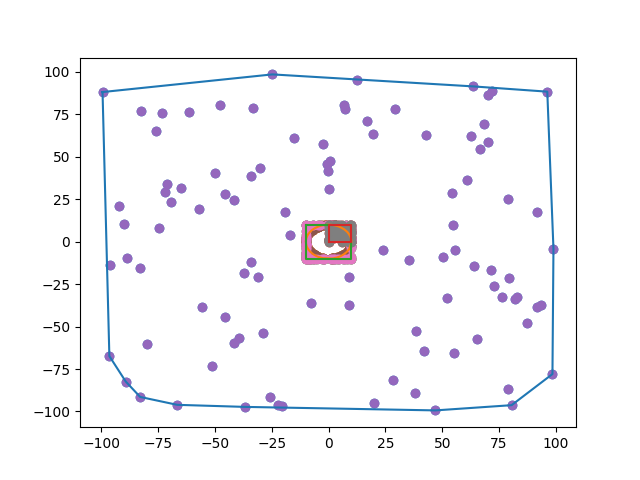

In [197]:
plt.scatter(*zip(*points_a))
plt.show()

In [198]:
plt.scatter(*zip(*points_b))
plt.show()

In [199]:
plt.scatter(*zip(*points_c))
plt.show()

In [200]:
plt.scatter(*zip(*points_d))
plt.show()

# Implementacja algorytmu Jarvisa

In [201]:
# Helper funcitons
def orientation(p, q, r, tolerance=10**(-14)):
    determinant = (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1]-q[1])
    if determinant > tolerance:
        return 1
    elif determinant < -tolerance:
        return -1
    else:
        return 0

def distance(p, q):
    return math.sqrt((p[0]-q[0])**2 + (p[1]-q[1])**2)

In [202]:
# Main implementation
def next_clockwise(points, p):
    n = len(points)
    q = (p+1) % n
    for i in range(n):
        orient = orientation(points[p], points[i], points[q]) 
        if orient == -1 or ( orient == 0 and distance(points[p], points[i]) >= distance(points[p], points[q])):
            q = i
    return q


def get_leftmost_index(points):
    result = 0
    for i, point in enumerate(points):
        if point[0] < points[result][0]:
            result = i
    return result


def jarvis_march(points):
    leftmost = get_leftmost_index(points)
    hull = [leftmost]
    p = next_clockwise(points, leftmost)
    while p != leftmost:
        hull.append(p)
        p = next_clockwise(points, p)
    return hull

### Rysowanie wyników algorytmu

In [204]:
plot_hull(jarvis_march(points_a), points_a, True)

In [205]:
plot_hull(jarvis_march(points_b), points_b, True)

In [206]:
plot_hull(jarvis_march(points_c), points_c, True)

In [207]:
plot_hull(jarvis_march(points_d), points_d, True)

# Sortowanie punktów względem kąta

In [208]:
def find_bottom_index(points):
    index = 0
    for i, point in enumerate(points):
        if point[1] < points[index][1] or (point[1] == points[index][1] and point[0] < points[index][0]):
            index = i
    return index

In [209]:
def get_polar_sorted(points, anchor=None, tolerance=10**(-8)):
    if anchor is None:
        anchor = points[find_bottom_index(points)]
        
    def key_value(p):
        y_span=anchor[1]-p[1]
        x_span=anchor[0]-p[0]
        return math.atan2(y_span, x_span)
    initial_sorted = sorted(points, key=key_value)
    result = [points[0]]
    for i in range(1, len(initial_sorted)):
        diff = abs(key_value(initial_sorted[i]) - key_value(initial_sorted[i-1]))
        if diff > tolerance:
            result.append(initial_sorted[i])
    return result

### Uwaga co do funkcji `get_polar_sorted`
Funkcja `get_polar_sorted` przy okazji sortowania usuwa punkty o tym samym kącie. 

<IPython.core.display.Javascript object>


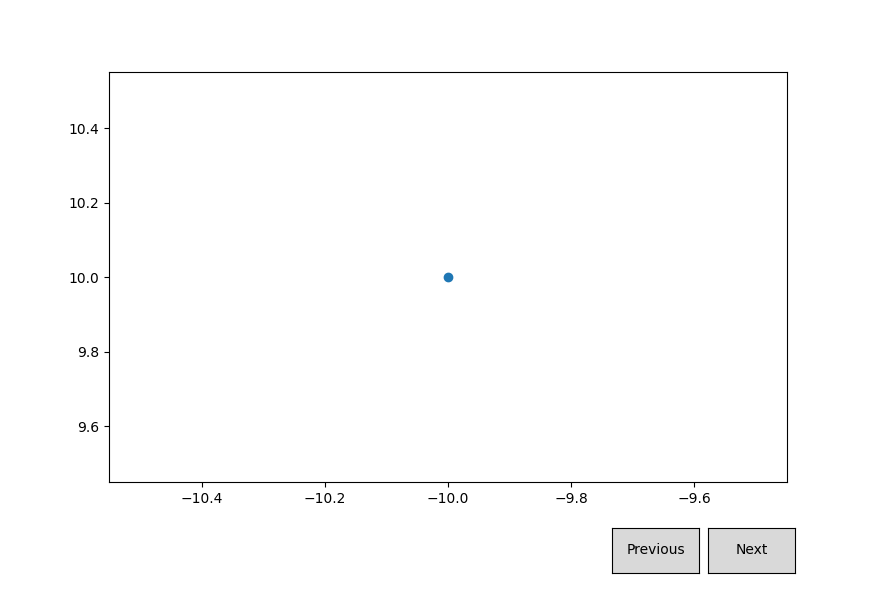

In [210]:
polar_sorted = get_polar_sorted(points_c)
bottom_point = pts[find_bottom_index(pts)]

frames = [Frame([PointsGroup([point])]) for point in polar_sorted]
plot = Plot(frames)


In [211]:
def grahams_scan(initial_points):
    points = get_polar_sorted(initial_points)
    stack = [0, 1, 2]
    
    for i in range(3, len(points)):
        while (len(stack) > 1 and orientation(points[stack[-2]], points[stack[-1]], points[i]) != -1):
            stack.pop()
        stack.append(i)
    return stack